# Model Definition Notebook 

## Convulational neural network

Install the proper version of tensorFlow and Keras packages

In [ ]:
!pip install --upgrade keras-applications keras-preprocessing setuptools tensorflow==1.14.0 keras==2.2.5

Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pickle

from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import *
from keras.activations import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import *
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import backend
from keras.models import model_from_json

from botocore.client import Config
import ibm_boto3

Using TensorFlow backend.
C:\Users\Jordi\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Jordi\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Jordi\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Jordi\AppData\Roa

In [ ]:
import tensorflow
if not tensorflow.__version__ == '1.14.0':
    print(tensorflow.__version__)
    raise ValueError('please upgrade to TensorFlow 1.14.0, or restart your Kernel (Kernel->Restart & Clear Output)')

import keras
if not keras.__version__ == '2.2.5':
    print(keras.__version__)
    raise ValueError('please upgrade to Keras 2.2.5, or restart your Kernel (Kernel->Restart & Clear Output)')

Define credentials to access a IBM cloud bucket storage

In [ ]:
# The code was removed by Watson Studio for sharing.

Load the training, validation and testing data

In [2]:
# load data
dataset = 'data_shuffled_scaled255.pickle'
cos.download_file(Bucket=credentials['BUCKET'], Key=dataset, Filename=dataset) 

with open(dataset, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

# transpose for images 32 x 32 x 3    
x_train = data['x_train'].transpose(0, 2, 3, 1)
x_validation = data['x_validation'].transpose(0, 2, 3, 1)
x_test = data['x_test'].transpose(0, 2, 3, 1)

#labels
labels = data['labels']

# shapes of pictures
height = x_train.shape[1]
width = x_train.shape[2]
depth = x_train.shape[3]
        
#sizes     
train_size = data['x_train'].shape[0]
validation_size = data['x_validation'].shape[0]
test_size = data['x_test'].shape[0]      
num_classes = data['labels'].shape[0] 

# One hot encoding
y_train = to_categorical(data['y_train'], num_classes=num_classes)
y_validation = to_categorical(data['y_validation'], num_classes=num_classes)
y_test = to_categorical(data['y_test'], num_classes=num_classes)

# Display shapes
print("x_train: ", x_train.shape)
print("x_validation: ", x_validation.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_validation: ", y_validation.shape)
print("y_test: ", y_test.shape)

x_train:  (86989, 32, 32, 3)
x_validation:  (4410, 32, 32, 3)
x_test:  (12630, 32, 32, 3)
y_train:  (86989, 43)
y_validation:  (4410, 43)
y_test:  (12630, 43)


In [3]:
# Define the Logistics Regression Model
def create_model(optimizer, lr, width, height, depth, num_classes):
   

    input_img = Input(shape=(width, height, depth))   

    x = Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding="same")(input_img)
    x = BatchNormalization()(x)
    x = Activation("relu")(x) 
    x = MaxPool2D()(x)
    
    x = Conv2D(filters=64, kernel_size=9, strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x) 
    x = MaxPool2D()(x)
    x = Dropout(0.1)(x)
    
    x = Conv2D(filters=128, kernel_size=18, strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x) 
    x = MaxPool2D()(x)
    x = Dropout(0.1)(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(num_classes)(x)
    output_pred = Activation("softmax")(x)
   
    optimizer = optimizer(lr=lr)
    model = Model(inputs=input_img, outputs=output_pred)
    model.compile(
        loss="categorical_crossentropy", 
        optimizer=optimizer, 
        metrics=["accuracy"])
    model.summary()
    
    return model

In [4]:
# hyperparameter
lr = 1e-3
optimizer = Adam
batch_size = 8
epochs = 15

In [5]:
# create model
model = create_model(optimizer, lr, width, height, depth, num_classes)

W1022 21:08:23.095917 10900 deprecation_wrapper.py:119] From C:\Users\Jordi\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 21:08:23.106860 10900 deprecation_wrapper.py:119] From C:\Users\Jordi\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 21:08:23.108883 10900 deprecation_wrapper.py:119] From C:\Users\Jordi\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1022 21:08:23.128801 10900 deprecation_wrapper.py:119] From C:\Users\Jordi\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        165952    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256 

In [7]:
# define learning rate sheduler
def schedule(epoch):
    lr = 0.001/(epoch+1)

    return lr

lrs = LearningRateScheduler(
    schedule=schedule,
    verbose=1)

In [8]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [9]:
# training
history = model.fit(
    x=x_train, 
    y=y_train, 
    verbose=1, 
    #batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(x_validation, y_validation),
    callbacks=[lrs, checkpoint])

W1022 21:09:03.016070 10900 deprecation.py:323] From C:\Users\Jordi\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 86989 samples, validate on 4410 samples
Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
86989/86989 [==============================] - 960s 11ms/step - loss: 1.3525 - acc: 0.5886 - val_loss: 0.4677 - val_acc: 0.8599

Epoch 00001: val_acc improved from -inf to 0.85986, saving model to weights-improvement-01-0.86.hdf5
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005.
86989/86989 [==============================] - 971s 11ms/step - loss: 0.2320 - acc: 0.9266 - val_loss: 0.2671 - val_acc: 0.9295

Epoch 00002: val_acc improved from 0.85986 to 0.92948, saving model to weights-improvement-02-0.93.hdf5
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0003333333333333333.
86989/86989 [==============================] - 944s 11ms/step - loss: 0.1294 - acc: 0.9593 - val_loss: 0.2030 - val_acc: 0.9401

Epoch 00003: val_acc improved from 0.92948 to 0.94014, saving model to weights-improvement-03-0.94.hdf5
E

We save the keras model and weights for later use

In [10]:
# serialize model to JSON
model_json = model.to_json()
with open('model_cnn3_2_b.json', "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model_cnn3_2_b.h5')

#upload feather object
cos.upload_file(Filename='cnn3_2.json', Bucket=credentials['BUCKET'], Key='cnn3_2.json') 
cos.upload_file(Filename='cnn3_2.h5', Bucket=credentials['BUCKET'], Key='cnn3_2.h5') 

print("Saved model to disk")

Saved model to disk


We save the history of the training fit of the model that includes the loss and metrics for every epoch, for plotting later without training the dataset again

In [11]:
with open('model_cnn3_2_b_history.pickle', 'wb') as f:
    pickle.dump(history, f)
    
cos.upload_file(Filename='model_logisticsRegression_history.pickle', Bucket=credentials['BUCKET'], Key='model_logisticsRegression_history.pickle') 

We load the model again with the weights

In [12]:
# load json and create model

#cos.download_file(Bucket=credentials['BUCKET'], Key='model_logisticsRegression.json', Filename='model_logisticsRegression.json')
#cos.download_file(Bucket=credentials['BUCKET'], Key='model_logisticsRegression.h5', Filename='model_logisticsRegression.h5')

with open("model_cnn3_2_b.json", "r") as json_file:
    loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_cnn3_2_b.h5")

print("Loaded model from disk")

Loaded model from disk


We load the history with the loss and the metrics obtained during training

In [13]:
#cos.download_file(Bucket=credentials['BUCKET'], Key='model_logisticsRegression_history.pickle', Filename='model_logisticsRegression_history.pickle') 

with open('model_cnn3_2_b_history.pickle', 'rb') as file:
    history = pickle.load(file, encoding='latin1')

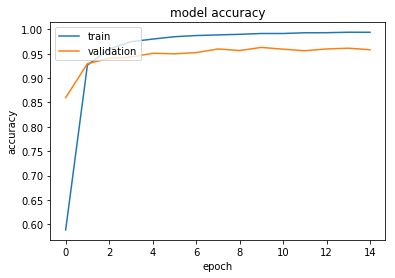

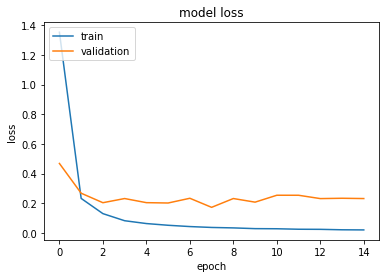

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
# score on test data
score = model.evaluate(x_test, y_test)
print("Test performance- Loss: ", score[0])
print("Test performance- Accuracy: ", score[1])

12630/12630 [==============================] - 13s 1ms/step
Test performance- Loss:  0.19448961613988114
Test performance- Accuracy:  0.9535233570579867


In [16]:
# store wrong predictions

pred = model.predict(x_test)

# init
wrong = np.array([])

for k in range(pred.shape[0]):
    ClassId_pred = np.argmax(pred[k])
    ClassId_true= np.argmax(y_test[k])
    if ClassId_pred != ClassId_true: 
        wrong = np.append(wrong, k)
        
print("Number of wrong predictions: ", wrong.size)
print("Percentage if wrong predictions: {0:.3f}".format((wrong.size/pred.shape[0])*100), "%")

Number of wrong predictions:  587
Percentage if wrong predictions: 4.648 %


Show some examples of wrong preditions

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


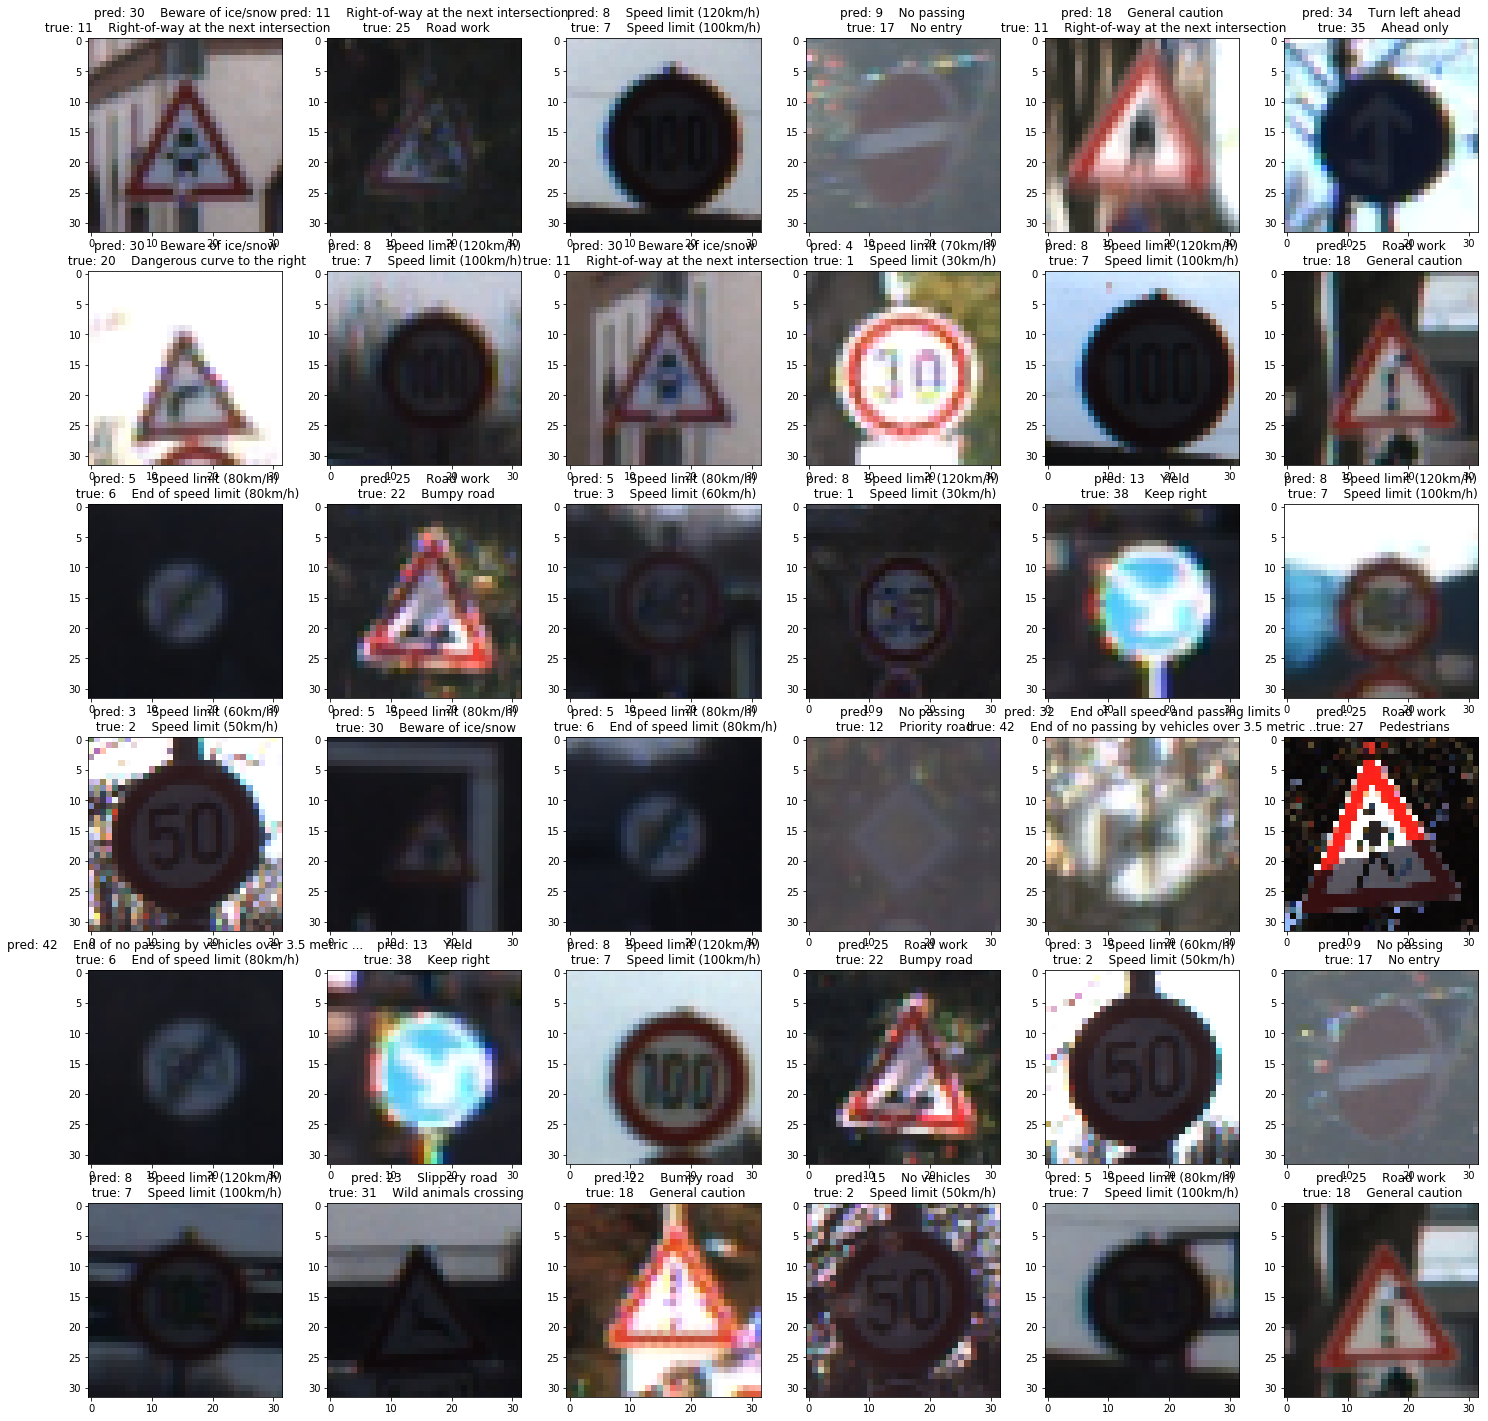

In [17]:
# show example images
rows = 6
cols = 6

fig, axs = plt.subplots(rows,cols, figsize = (25,25))

for i in range(rows):
    for j in range(cols):
            ClassId_pred = np.argmax(pred[int(wrong[rows*i+j])])
            label_pred = labels[labels["ClassId"] == ClassId_pred]["SignName"].to_string()
            ClassId_true= np.argmax(y_test[int(wrong[rows*i+j])])
            label_true = labels[labels["ClassId"] == ClassId_true]["SignName"].to_string()
            axs[i,j].imshow(x_test[int(wrong[rows*i+j])])
            axs[i,j].set_title("pred: "+label_pred+"\n true: "+label_true)
    
fig.show()